In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import ShuffleSplit

%matplotlib inline

### Loading and Pre-Processing Data

In [3]:
train_df = pd.read_csv("Data/train.csv")
valid_df = pd.read_csv("Data/test.csv")

X_train = train_df.drop(['label'], axis=1).values.astype('float32')
y_train = train_df['label'].values
X_valid = valid_df.values.astype('float32')

scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

img_h = 28
img_w = 28
n_samples = len(X_train_scaled)
n_targets = 10

print('Training samples:', n_samples)

Training samples: 42000


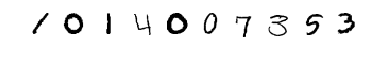

In [4]:
# The data that we are interested in is made of 28x28 images of digits, let's
# have a look at the first images, stored in X_train. For these
# images, we know which digit they represent: it is given by the correspondent y_train.
images_and_labels = list(zip(X_train, y_train))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 10, index + 1)
    plt.axis('off')
    plt.imshow(image.reshape(img_h, img_w), cmap=plt.cm.gray_r, interpolation='nearest')

### Scikit-Learn Visualization 

In [5]:
def plot_confusion_matrix(model_name, y_test, predicted, df_cm):
    """
    Generates a good visualization for confusion matrices.
    
    Parameters
    ----------
    model_name : string
        The model used to train the data.
    y : array-like, shape (n_samples, n_targets)
        The test data targets.
    predicted : array-like, shape (n_samples, n_targets)
        The predicted targets.
    df_cm : pandas dataframe, shape (n_targets, n_targets)   
        The confusion matrix.
    """
    plt.figure(figsize=(5.5,4))
    sn.heatmap(df_cm, annot=True)
    plt.title(model_name+' \nAccuracy:{0:.3f}'.format(accuracy_score(y_test,predicted)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.
    title : string
        Title for the chart.
    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.
    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.
    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.
    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.
        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.
    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

In [7]:
def plot_decision_boundary(X, y, fitted_model):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.
    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.
    fitted_model : sklean fitting model
        Instance for the model used to fit X.
    """
    plt.figure(figsize=(9.8,5), dpi=100)
    
    for i, plot_type in enumerate(['Decision Boundary', 'Decision Probabilities']):
        plt.subplot(1,2,i+1)

        mesh_step_size = 0.01  # step size in the mesh
        x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
        y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size), np.arange(y_min, y_max, mesh_step_size))
        if i == 0:
            Z = fitted_model.predict(np.c_[xx.ravel(), yy.ravel()])
        else:
            try:
                Z = fitted_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
            except:
                plt.text(0.4, 0.5, 'Probabilities Unavailable', horizontalalignment='center',
                     verticalalignment='center', transform = plt.gca().transAxes, fontsize=12)
                plt.axis('off')
                break
        Z = Z.reshape(xx.shape)
        plt.scatter(X[y.values==0,0], X[y.values==0,1], alpha=0.4, label='Edible', s=5)
        plt.scatter(X[y.values==1,0], X[y.values==1,1], alpha=0.4, label='Posionous', s=5)
        plt.imshow(Z, interpolation='nearest', cmap='RdYlBu_r', alpha=0.15, 
                   extent=(x_min, x_max, y_min, y_max), origin='lower')
        plt.title(plot_type + '\n' + 
                  str(fitted_model).split('(')[0]+ ' Test Accuracy: ' + str(np.round(fitted_model.score(X, y), 5)))
        plt.gca().set_aspect('equal');
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.08, wspace=0.02)

In [9]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

### Support Vector Machine

In [10]:
from sklearn.svm import SVC

#### RBF Kernel

In [ ]:
validation_curve(SVC(kernel='rbf'), X_train_scaled, y_train, "gamma", np.logspace(-7, 3, 3))

In [ ]:
svm = SVC(kernel='rbf', gamma=0.001).fit(X_train_scaled, y_train)
svm_predicted = svm.predict(X_valid_scaled)

In [ ]:
scores = cross_val_score(svm, X_train_scaled, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
images_and_predictions = list(zip(X_valid_scaled, svm_predicted))
for index, (image, prediction) in enumerate(images_and_predictions[104]):
    plt.subplot(2, 4, index + 5)
    plt.axis('off')
    plt.imshow(image.reshape(img_h, img_w), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('%i' % prediction)

#### Linear Kernel

In [ ]:
title = "Learning Curves (SVM, Linear kernel, $C=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(kernel='linear', C=0.001)
plot_learning_curve(estimator, title, X_train_scaled, y_train, (0.7, 1.01), cv=cv, n_jobs=4)

In [ ]:
svm = SVC(kernel='linear', C=0.001).fit(X_train_scaled, y_train)
svm_predicted = svm.predict(X_valid_scaled)

In [ ]:
images_and_predictions = list(zip(X_valid_scaled, svm_predicted))
for index, (image, prediction) in enumerate(images_and_predictions[104]):
    plt.subplot(2, 4, index + 5)
    plt.axis('off')
    plt.imshow(image.reshape(img_h, img_w), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('%i' % prediction)

### Convolutional Neural Networks

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [ ]:
X_train_scaled = X_train_scaled.reshape(n_samples, img_h, img_w, 1)
x_valid_scaled = x_valid_scaled.reshape(n_samples, img_h, img_w, 1)

In [ ]:
# The y_train is not split into 10 distinct class labels, but rather 
# are represented as a single array with the class values
y_train = to_categorical(y_train, n_targets)
print(y_train)

#### Model Architecture

---

1. Basic Concepts:   
    * [2D Convolution](https://keras.io/layers/convolutional/#convolution2d)
    
    The main concept to implement a CNN. This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.
    
    * [Max Pooling](https://keras.io/layers/pooling/#maxpooling2d)
    
    Reduces the size of the filter maps, by applying a max filter to non-overlapping subregions. A max pooling layer with pooling_size=2 will reduce the number total number of parameters in the filter map by a factor of 4.
    
    * [Dropout](https://keras.io/layers/core/#dropout)
    
   Consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.
   
   * [Flatten](https://keras.io/layers/core/#flatten)
   
   Flattens the input. Does not affect the batch size.
   
   * [Dense](https://keras.io/layers/core/#dense)
   
   Just a regular densely-connected NN layer.
   
   * [Activation](https://keras.io/layers/core/#activation)
   
   Applies an activation function to an output.

2. Architecture:

    * Sequential Model
    * Convolutional Layer 
    * MaxPooling
    * Convolutional Layer 
    * MaxPooling
    * Dropout
    * Dense Layer

3. Obs:

     * [Epoch vs Batch Size vs Iterations](https://stackoverflow.com/questions/4752626/epoch-vs-iteration-when-training-neural-networks)
     * [Optimizers](https://keras.io/optimizers/)
     * [Loss Functions](https://keras.io/losses/)

In [ ]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, activation='relu', (None, 1, img_h, img_w), border_mode='valid'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(32, 3, 3, activation='relu', (None, 1, img_h, img_w), border_mode='valid'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])
model.fit(X_train_scaled, y_train, batch_size=32, nb_epoch=10, verbose=1)

In [ ]:
pred = model.predict_classes(x_valid_scaled)

np.savetxt('mnist-vggnet.csv', np.c_[range(1,len(pred)+1),pred], delimiter=',', header = 'ImageId,Label', comments = '', fmt='%d')